**Bài toán 1:** Tìm tập phổ biến trong dữ liệu giao dịch mua hàng tại siêu thị. Dữ liệu có thể lấy từ
https://www.kaggle.com/code/mgmarques/customer-segmentation-and-market-basket-analysis

**Nhiệm vụ 1:** Xác định các luật kết hợp

### 1. Thực hiện các bước từ 1 đến 4 và chọn 1 trong 3 case của bước 5 để tìm tập phổ biến có trong dữ liệu giao dịch dạng bảng của siêu thị

1. Cài đặt các thư viện mlxtend và import các gói dữ liệu

In [10]:
# To install mlxtend, go to the Anaconda prompt and execute pip
import matplotlib.pyplot as plt
import mlxtend.frequent_patterns
import mlxtend.preprocessing
import numpy
import pandas

2. Thực hiện một số tính toán để hiểu các khái niệm cơ bản như support, confident và lift

In [13]:
# danh sách các giao dịch mua hàng
example = [
['milk', 'bread', 'apples', 'cereal', 'jelly', 'cookies', 'salad', 'tomatoes'],
['beer', 'milk', 'chips', 'salsa', 'grapes', 'wine', 'potatoes', 'eggs', 'carrots'],
['diapers', 'baby formula', 'milk', 'bread', 'chicken', 'asparagus', 'cookies'],
['milk', 'cookies', 'chicken', 'asparagus', 'broccoli', 'cereal', 'orange juice'],
['steak', 'asparagus', 'broccoli', 'chips', 'salsa', 'ketchup', 'potatoes', 'salad'],
['beer', 'salsa', 'asparagus', 'wine', 'cheese', 'crackers', 'strawberries', 'cookies'],
['chocolate cake', 'strawberries', 'wine', 'cheese', 'beer', 'milk', 'orange juice'],
['chicken', 'peas', 'broccoli', 'milk', 'bread', 'eggs', 'potatoes', 'ketchup', 'crackers'],
['eggs', 'bread', 'cheese', 'turkey', 'salad', 'tomatoes', 'wine', 'steak', 'carrots'],
['bread', 'milk', 'tomatoes', 'cereal', 'chicken', 'turkey', 'chips', 'salsa', 'diapers']
]
# Tính support
# the number of transactions
N = len(example)
# the frequency of milk
f_x = sum(['milk' in i for i in example])
# the frequency of bread
f_y = sum(['bread' in i for i in example])
# the frequency of milk and bread
f_x_y = sum([
all(w in i for w in ['milk', 'bread'])
for i in example
])
# support (supp)
support = f_x_y / N
print("Support = {}".format(round(support, 4))) # support = 0.4
# confidence: x -> y
confidence = support / (f_x / N)
print("Confidence = {}".format(round(confidence, 4)))# Confidence = 0.5714
# lift: x -> y
lift = confidence / (f_y / N)
print("Lift = {}".format(round(lift, 4))) # Lift = 1.1429
# leverage: x -> y
leverage = support - ((f_x / N) * (f_y / N))
print("Leverage = {}".format(round(leverage, 4)))
# conviction: x -> y
conviction = (1 - (f_y / N)) / (1 - confidence)
print("Conviction = {}".format(round(conviction, 4)))

Support = 0.4
Confidence = 0.5714
Lift = 1.1429
Leverage = 0.05
Conviction = 1.1667


3. Nạp dữ liệu, làm sạch dữ liệu và biến đổi dữ liệu về định dạng phù hợp để thực hiện xây dựng mô hình
(chuyển dữ liệu từ 1 hóa đơn có nhiều dòng thành 1 hóa đơn chỉ có 1 dòng chứa các sản phẩm)

In [32]:
online = pandas.read_excel( io="Data/Online Retail.xlsx/Online Retail.xlsx", sheet_name="Online Retail", header=0 )
# create new column called IsCPresent
online['IsCPresent'] = ( # looking for C in InvoiceNo column
    online['InvoiceNo'] # convert column to string type for the apply function below

    .astype(str) # set element to 1 if C present otherwise 0
    .apply(lambda x: 1 if x.find('C') != -1 else 0)
)
online1 = (
    online # filter out non-positive quantity values
    .loc[online["Quantity"] > 0] # remove InvoiceNos starting with C
    .loc[online['IsCPresent'] != 1] # column filtering
    .loc[:, ["InvoiceNo", "Description"]]# dropping all rows with at least one missing value.dropna()
)
# extract unique invoice numbers as list
invoice_no_list = online1.InvoiceNo.tolist()
invoice_no_list = list(set(invoice_no_list))
print("Length of list of invoice numbers:{ln}".format(ln=len(invoice_no_list)))

# get 5000 transaction
subset_invoice_no_list = invoice_no_list[0:5000]
# filter data set down to based on subset of invoice number list
online1 = online1.loc[online1["InvoiceNo"].isin(subset_invoice_no_list)]
invoice_item_list = []
for num in list(set(online1.InvoiceNo.tolist())):
    # filter data set down to one invoice number
    tmp_df = online1.loc[online1['InvoiceNo'] == num]
    # extract item descriptions and convert to list
    tmp_items = tmp_df.Description.tolist()
    # append list invoice_item_list
    invoice_item_list.append(tmp_items)
print(invoice_item_list[1:5])

Length of list of invoice numbers:20728
[['HAND WARMER UNION JACK', 'HAND WARMER RED POLKA DOT'], ['ASSORTED COLOUR BIRD ORNAMENT', "POPPY'S PLAYHOUSE BEDROOM ", "POPPY'S PLAYHOUSE KITCHEN", 'FELTCRAFT PRINCESS CHARLOTTE DOLL', 'IVORY KNITTED MUG COSY ', 'BOX OF 6 ASSORTED COLOUR TEASPOONS', 'BOX OF VINTAGE JIGSAW BLOCKS ', 'BOX OF VINTAGE ALPHABET BLOCKS', 'HOME BUILDING BLOCK WORD', 'LOVE BUILDING BLOCK WORD', 'RECIPE BOX WITH METAL HEART', 'DOORMAT NEW ENGLAND'], ['JAM MAKING SET WITH JARS', 'RED COAT RACK PARIS FASHION', 'YELLOW COAT RACK PARIS FASHION', 'BLUE COAT RACK PARIS FASHION'], ['BATH BUILDING BLOCK WORD']]


4. Mã hóa dữ liệu về dạng dữ liệu mà giải thuật apriori trong gói mlxtend yêu cầu

In [34]:
# Clean invoice_item_list: remove NaN or non-string items and drop empty transactions
clean_invoice_item_list = [
	[item for item in trans if isinstance(item, str) and not pandas.isna(item)]
	for trans in invoice_item_list
]
clean_invoice_item_list = [trans for trans in clean_invoice_item_list if trans]

online_encoder = mlxtend.preprocessing.TransactionEncoder()
online_encoder_array = online_encoder.fit_transform(clean_invoice_item_list)
online_encoder_df = pandas.DataFrame(
	online_encoder_array,
	columns=online_encoder.columns_
)
# this is a very big table, so for more easy viewing only a subset is printed
online_encoder_df.loc[
	4970:4979,
	online_encoder_df.columns.tolist()[0:8]
]
print("Data dimension (row count, col count): {dim}".format(dim=online_encoder_df.shape))

Data dimension (row count, col count): (4840, 3124)


5. Tìm tập phổ biến bằng giải thuật apriori

In [35]:
# case 3: add colnames for easier interpretability 
mod_colnames_minsupport = mlxtend.frequent_patterns.apriori( 
 online_encoder_df, 
 min_support=0.01, 
 use_colnames=True 
) 
mod_colnames_minsupport['length'] = ( 
 mod_colnames_minsupport['itemsets'].apply(lambda x: len(x)) 
) 
mod_colnames_minsupport.loc[0:6]

,support,itemsets,length
0,0.011364,( OVAL WALL MIRROR DIAMANTE ),1
1,0.034091,( SET 2 TEA TOWELS I LOVE LONDON ),1
2,0.017562,(10 COLOUR SPACEBOY PEN),1
3,0.012603,(12 IVORY ROSE PEG PLACE SETTINGS),1
4,0.013636,(12 MESSAGE CARDS WITH ENVELOPES),1
5,0.017769,(12 PENCIL SMALL TUBE WOODLAND),1
6,0.027479,(12 PENCILS SMALL TUBE RED RETROSPOT),1


### 2. Trích các luật có trong tập phổ biến đã thực hiện ở bước 1

In [46]:
# case 1: hiển thị 6 luật trong 1064 luật được tìm thấy 
rules = mlxtend.frequent_patterns.association_rules( 
    mod_colnames_minsupport, 
    metric="confidence", 
    min_threshold=0.6,  
    support_only=False 
) 
rules.loc[0:6] 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(12 PENCILS SMALL TUBE SKULL),(12 PENCILS SMALL TUBE RED RETROSPOT),0.022107,0.027479,0.015289,0.691589,25.167592,1.0,0.014682,3.153325,0.981975,0.445783,0.682874,0.623990
1,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE GREEN),0.020661,0.054959,0.014050,0.680000,12.372932,1.0,0.012914,2.953254,0.938570,0.228188,0.661390,0.467820
2,(ALARM CLOCK BAKELIKE CHOCOLATE),(ALARM CLOCK BAKELIKE RED ),0.020661,0.052479,0.014050,0.680000,12.957480,1.0,0.012965,2.961002,0.942293,0.237762,0.662276,0.473858
3,(ALARM CLOCK BAKELIKE IVORY),(ALARM CLOCK BAKELIKE GREEN),0.026653,0.054959,0.016116,0.604651,11.001923,1.0,0.014651,2.390399,0.934001,0.246057,0.581660,0.448942
4,(ALARM CLOCK BAKELIKE ORANGE),(ALARM CLOCK BAKELIKE GREEN),0.027893,0.054959,0.020661,0.740741,13.478140,1.0,0.019128,3.645159,0.952370,0.332226,0.725664,0.558340
5,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.052479,0.054959,0.035744,0.681102,12.392990,1.0,0.032860,2.963463,0.970226,0.498559,0.662557,0.665739
6,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.054959,0.052479,0.035744,0.650376,12.392990,1.0,0.032860,2.710113,0.972771,0.498559,0.631012,0.665739


In [47]:
# case 2: liệt kê các rule thỏa mãn điều kiện min_threshold 
rules2 = mlxtend.frequent_patterns.association_rules( 
    mod_colnames_minsupport,  
    metric="lift", #có thể sử dụng support, confidence, ... 
    min_threshold=50,  
    support_only=False 
) 
rules2.loc[0:6]
print("Number of Associations: {}".format(rules2.shape[0])) # 170 luật 

Number of Associations: 186


### 3. Hình vẽ cho thấy mối quan hệ giữa support, confidence của luật

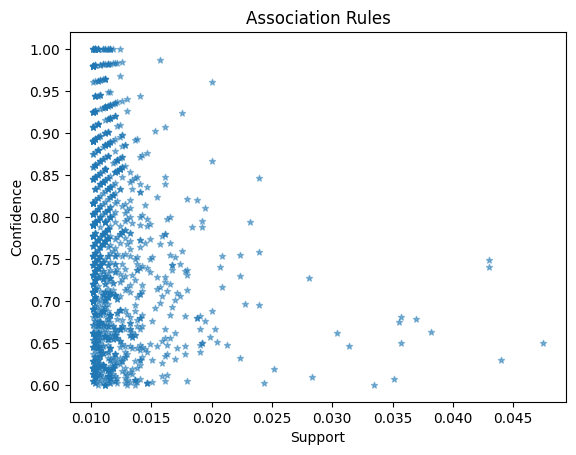

In [43]:
rules.plot.scatter("support", "confidence", alpha=0.5, marker="*") 
plt.xlabel("Support") 
plt.ylabel("Confidence") 
plt.title("Association Rules") 
plt.show()

### 4. Hình vẽ cho thấy mối quan hệ giữa số item và confidence của luật

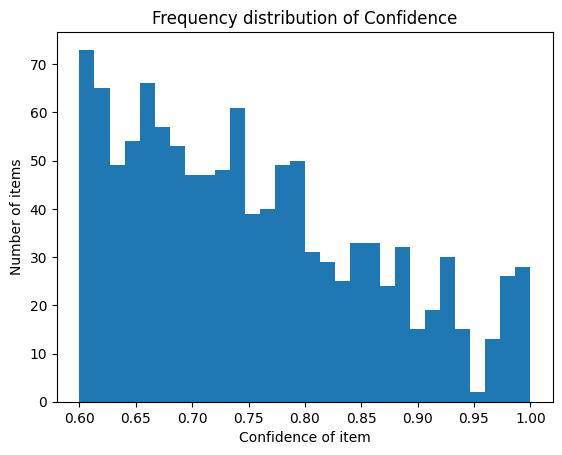

In [44]:
rules.hist("confidence", grid=False, bins=30) 
plt.xlabel("Confidence of item") 
plt.ylabel("Number of items") 
plt.title("Frequency distribution of Confidence") 
plt.show()